In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from umap import UMAP
from sklearn.cluster import KMeans
import plotly.express as px # for data visualization
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import OPTICS

In [33]:
FILTER_GENES = False

In [34]:
data = pd.read_csv('/content/drive/MyDrive/mgitech/E14.5_E1S3_Dorsal_Midbrain_GEM_CellBin_merge.tsv.gz', compression='gzip', header=0, sep='\t')
data.head()

,geneID,x,y,MIDCounts,cell
0,Arpc1b,19881,9379,3,170675
1,B230118H07Rik,19881,9379,2,170675
2,Bcl2l12,19881,9379,1,170675
3,Ccnd3,19881,9379,1,170675
4,Cdk8,19881,9379,3,170675


Amount of cells: 4872
Unique genes: 18698
Max expression (MIDCounts) 433
Most overexpressed genes:
 geneID
Gm42418    66.450867
Cdk8        8.127765
Tmsb4x      5.893888
Hbb-bs      5.295998
Tuba1a      5.083864
Name: MIDCounts, dtype: float64


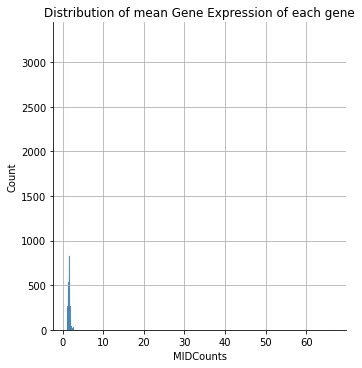

In [35]:
#exploration
def exploration(data):
  print("Amount of cells:", data['cell'].unique().shape[0])
  print("Unique genes:", data['geneID'].unique().shape[0])
  print("Max expression (MIDCounts)", data['MIDCounts'].max())
  data = data.groupby(by=['cell', 'geneID']).sum()
  
  data_gene = data.groupby(by='geneID').mean()
  print("Most overexpressed genes:\n", 
        data_gene.sort_values(by=['MIDCounts'], ascending=False)['MIDCounts'].head())
  sns.displot(
        data=data_gene,
        x="MIDCounts",
        kind="hist"
        ).set(title='Distribution of mean Gene Expression of each gene')

  #plt.ylim(0, 1000)
  #plt.xlim(0, 5)
  plt.grid()
  plt.show()
exploration(data)

In [36]:
data_p = data.pivot_table('MIDCounts', index='cell', columns='geneID', aggfunc='sum', fill_value=0)

In [37]:
if FILTER_GENES:
    data_p = data_p[['Mki67', 'Dbx1', 'Aldh1l1', 'Efna5', 'Npas3', 'Adgrb3', 'Ccnd2', 'Nes', 
                      'Nrxn3', 'Gad2', 'Tenm3', 'Dcc', 'Nrxn1', 'Nrg3', 'Apoe', 'C1qc']]

In [38]:
data = data.groupby(by='cell').mean()
coords = pd.merge(data_p, data, on=['cell'])[['x', 'y']]

In [39]:
data

,x,y,MIDCounts
cell,,,
170675,19881.0,9379.0,2.031579
170785,19875.0,9350.0,1.700000
170808,19886.0,9330.0,2.011628
170818,19904.0,9160.0,1.603448
170819,19902.0,9216.0,1.754386
...,...,...,...
181840,22663.0,6831.0,1.787879
181841,22654.0,6877.0,2.189831
181842,22666.0,6906.0,1.761719


In [40]:
# dimension reduction

In [41]:
class DimReduce:
    def __init__(self, data):
        self.data = data

    def umap_reducer(self, n_components=2):
        # Configure UMAP hyperparameters
        model_name = 'UMAP'

        reducer = UMAP(n_neighbors=100,
                      n_components=n_components, 
                      metric='euclidean', 
                      n_epochs=1000,  
              )

        # Fit and transform the data
        X_trans = reducer.fit_transform(self.data)

        return X_trans, model_name


    def tsne_reducer(self, n_components=2):

        model_name = 't-SNE'

        reducer = TSNE(n_components=n_components, 
                      learning_rate='auto',
                      init='random', 
                      perplexity=3)
        
        # Fit and transform the data
        X_trans = reducer.fit_transform(self.data)

        return X_trans, model_name

    def pca_reducer(self, n_components=2):

        model_name = 'PCA'

        reducer = PCA(n_components=n_components)

        # Fit and transform the data
        X_trans = reducer.fit_transform(self.data)

        return X_trans, model_name
    

    def plot_2D(self, X, model_name):
        plt.figure()
        plt.plot(X.T[0], X.T[1], '.')
        plt.grid()
        plt.title(model_name)
        plt.xlabel('x')
        plt.ylabel('y')


    def plot_3D(self, X, model_name, y = None):
        #--------------------------------------------------------------------------#
        # This section is not mandatory as its purpose is to sort the data by label 
        # so, we can maintain consistent colors for digits across multiple graphs

        # If data doesn't have labels, create y
        if y is None:
            y = np.zeros(X_trans.shape[0], )
        
        # Concatenate X and y arrays
        arr_concat=np.concatenate((X, y.reshape(y.shape[0],1)), axis=1)
        # Create a Pandas dataframe using the above array
        df=pd.DataFrame(arr_concat, columns=['x', 'y', 'z', 'label'])
        # Convert label data type from float to integer
        df['label'] = df['label'].astype(int)
        # Finally, sort the dataframe by label
        df.sort_values(by='label', axis=0, ascending=True, inplace=True)
        #--------------------------------------------------------------------------#
        
        # Create a 3D graph
        fig = px.scatter_3d(df, x='x', y='y', z='z', color=df['label'].astype(str), height=900, width=950)

        # Update chart looks
        fig.update_layout(title_text=model_name,
                          showlegend=True,
                          legend=dict(orientation="h", yanchor="top", y=0, xanchor="center", x=0.5),
                          scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                                center=dict(x=0, y=0, z=-0.1),
                                                eye=dict(x=1.5, y=-1.4, z=0.5)),
                                                margin=dict(l=0, r=0, b=0, t=0),
                          scene = dict(xaxis=dict(backgroundcolor='white',
                                                  color='black',
                                                  gridcolor='#f0f0f0',
                                                  title_font=dict(size=10),
                                                  tickfont=dict(size=10),
                                                ),
                                      yaxis=dict(backgroundcolor='white',
                                                  color='black',
                                                  gridcolor='#f0f0f0',
                                                  title_font=dict(size=10),
                                                  tickfont=dict(size=10),
                                                  ),
                                      zaxis=dict(backgroundcolor='lightgrey',
                                                  color='black', 
                                                  gridcolor='#f0f0f0',
                                                  title_font=dict(size=10),
                                                  tickfont=dict(size=10),
                                                )))
        # Update marker size
        fig.update_traces(marker=dict(size=3, line=dict(color='black', width=0.1)))
        
        fig.show()

In [42]:
reducer = DimReduce(data_p)

In [43]:
X_trans, model_name = reducer.umap_reducer(n_components=2)

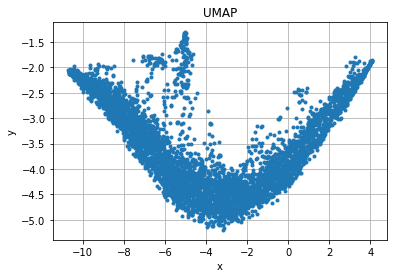

In [44]:
reducer.plot_2D(X_trans, model_name)

In [64]:
X_trans, model_name = reducer.tsne_reducer(n_components=2)

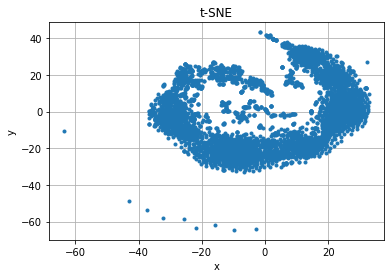

In [65]:
reducer.plot_2D(X_trans, model_name)

In [66]:
X_trans, model_name = reducer.pca_reducer(n_components=2)

In [67]:
reducer.plot_2D(X_trans, model_name)

In [49]:
# clusterisation

In [50]:
class Clusters:
    def __init__(self, data):
        self.data = data

    def k_mean_clusters(self, n_clusters=2):

        model_name = 'KMeans'

        cluster_model = KMeans(n_clusters=n_clusters, random_state=0)

        X_clust = cluster_model.fit(self.data).labels_

        return X_clust, model_name

    def aglomerative_cluster(self, n_clusters = 2):
        model_name = 'AgglomerativeClustering'

        cluster_model = AgglomerativeClustering(n_clusters = n_clusters)

        X_clust = cluster_model.fit(self.data).labels_

        return X_clust, model_name

    def dbscan(self, eps=0.5, min_samples=10):

        model_name = 'DBSCAN'

        cluster_model = DBSCAN(eps=eps, min_samples=min_samples)
        
        X_clust = cluster_model.fit(self.data).labels_

        return X_clust, model_name


    def histogram(self, X, model_name):

        plt.figure()
        plt.hist(X, bins = len(set(X)))
        plt.title(model_name)
        plt.xlabel('Cluster number')
        plt.ylabel('Count samples')
        plt.grid()

    def clusters_plot(self, X, coords,  model_name):

        coords['label'] = X

        plt.figure(figsize=(10, 7))

        for label in pd.unique(X):
            
            data_l = coords[coords['label'] == label]
            plt.plot(data_l['y'], data_l['x'], '.', label = label)
            plt.title(model_name)
            plt.xlabel('x')
            plt.ylabel('y')
            plt.grid()
            plt.legend(loc="center right")


    def clusters_reduce_plot(self, labels, X_trans,  model_name):

        X_trans_d = pd.DataFrame(X_trans, columns=('x', 'y'))
        X_trans_d['label'] = labels

        plt.figure(figsize=(10, 7))

        for label in pd.unique(labels):
            
            data_l = X_trans_d[X_trans_d['label'] == label]
            plt.plot(data_l['y'], data_l['x'], '.', label = label)
            plt.title(model_name)
            plt.xlabel('x')
            plt.ylabel('y')
            plt.grid()
            plt.legend(loc="center right")

    


    

In [51]:
clusters = Clusters(data_p)
# clusters = Clusters(X_trans)

In [52]:
X_clust, model_name = clusters.k_mean_clusters(n_clusters=11)

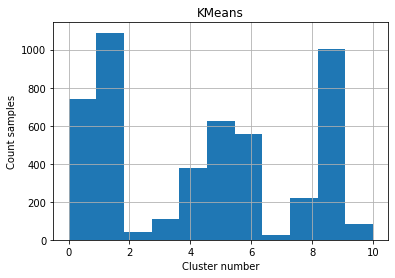

In [53]:
clusters.histogram(X_clust, model_name)

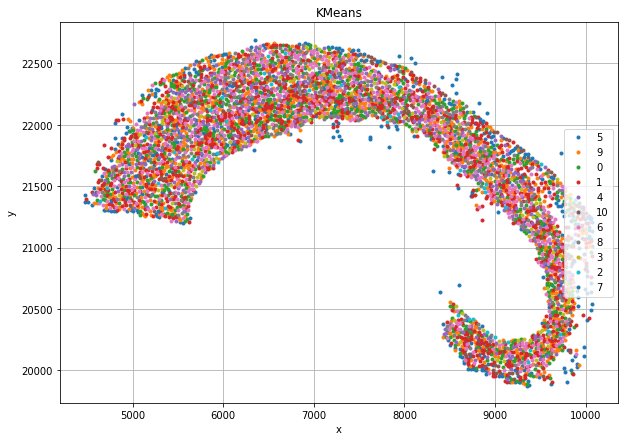

In [54]:
clusters.clusters_plot(X_clust, coords,  model_name)

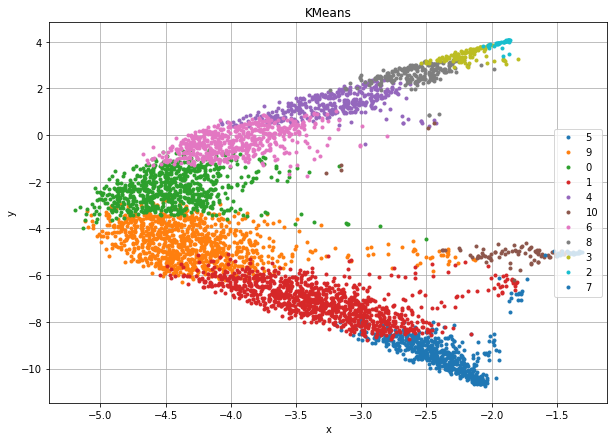

In [55]:
clusters.clusters_reduce_plot(X_clust, X_trans,  model_name)

In [56]:
X_clust, model_name = clusters.aglomerative_cluster(n_clusters=11)

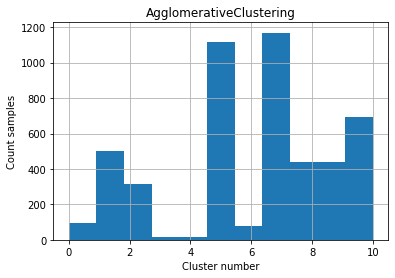

In [57]:
clusters.histogram(X_clust, model_name)

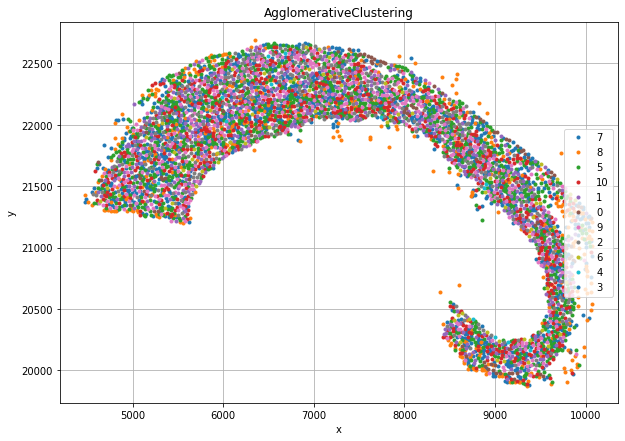

In [58]:
clusters.clusters_plot(X_clust, coords,  model_name)

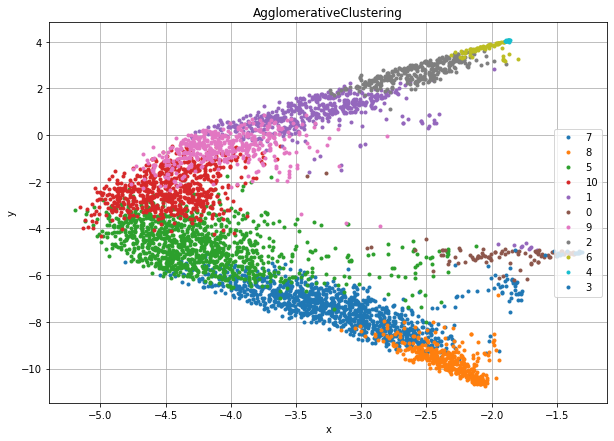

In [59]:
clusters.clusters_reduce_plot(X_clust, X_trans,  model_name)

In [60]:
X_clust, model_name = clusters.dbscan(eps = 50.0)

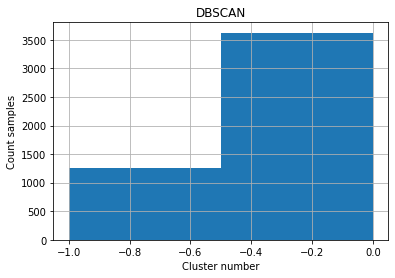

In [61]:
clusters.histogram(X_clust, model_name)

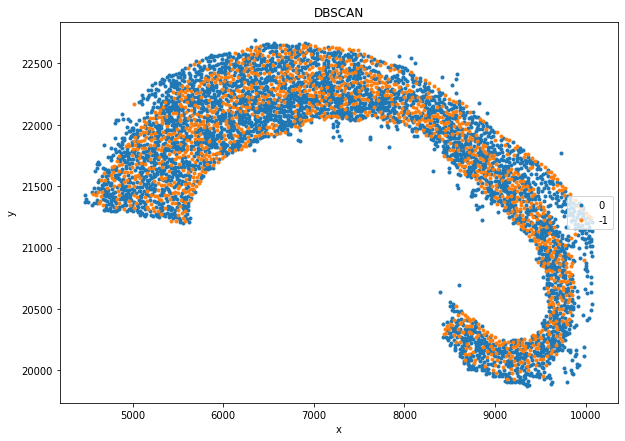

In [62]:
clusters.clusters_plot(X_clust, coords,  model_name)

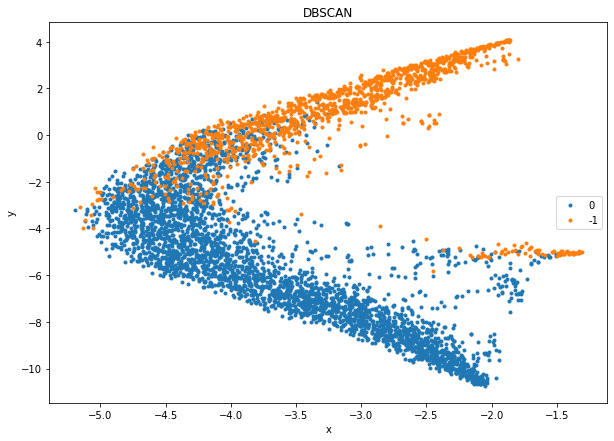

In [63]:
clusters.clusters_reduce_plot(X_clust, X_trans,  model_name)